This script is the first test of the SBI method for extracting the power spectrum of pressure fluctuation with PITSZI

# Imports

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
import copy
from astropy.wcs import WCS
from chainconsumer import ChainConsumer, Chain, Truth
from chainconsumer.plotting import plot_contour, plot_truths
import torch
from sbi import utils as utils
from sbi.inference import infer
import pitszi

# The baseline cluster model

In [2]:
do_mcmc = False
MCMC_Nstep = 300

outdir = '/Users/adam/Desktop/PITSZItestSBI'

In [3]:
input_norm = 0.5
input_Linj = 500

In [4]:
base_cluster = pitszi.Model(silent=True, redshift=0.5, M500=1e15*u.Msun)
base_cluster.set_pressure_profile_universal_param('A10MD')
base_cluster.model_pressure_profile['c'] = 0
base_cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                           'statistics': 'gaussian',
                                           'Norm': input_norm,
                                           'slope': -11./3,
                                           'Linj': input_Linj*u.kpc,
                                           'Ldis': 1*u.kpc}
base_cluster.map_reso = 8*u.arcsec
base_cluster.los_reso = 50*u.kpc
base_cluster.los_size = 2*u.Mpc
base_cluster.give_sampling_information()

===== Information relative to the grid sampling =====
   Grid size : 37 , 37 , 41
   Pixel size :      50.3     kpc ;     8.0      arcsec
   Fov size :  [   1861.3   ,   1861.3   ] kpc ; [   4.933    ,   4.933    ] arcmin
   L.o.S. resolution :         50.0     kpc
   Map center :   <SkyCoord (ICRS): (ra, dec) in deg
    (4.29649529e-31, 0.)>
   k min/max projected :       0.003378  /  0.060811   1/arcsec
   k min/max projected :       0.000537  /  0.009671   1/kpc
   k min/max L.o.S. (eq.) :    0.003067  /  0.061349   1/arcsec
   k min/max L.o.S. :          0.000488  /  0.009756   1/kpc
   k max Nyquist :             0.060811   1/arcsec
   k max Nyquist :             0.009671   1/kpc


In [5]:
Npkbin = 30
kmin = 2/base_cluster.get_map_fov()[0].to('arcmin')
kmax = 1/(2*base_cluster.get_map_reso().to('arcmin'))
print('kmin, kmax: ', kmin.to('arcsec-1'), kmax.to('arcsec-1'))

kmin, kmax:  0.006756756756756824 1 / arcsec 0.06250000000000062 1 / arcsec


# Define simulators

In [6]:
test_cluster = copy.deepcopy(base_cluster)

def simulator_img(theta):
    norm, Linj = np.asarray(theta)
    test_cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                               'statistics': 'gaussian',
                                               'Norm': norm,
                                               'slope': -11./3,
                                               'Linj': Linj*u.kpc,
                                               'Ldis': 1*u.kpc}
    sz_img = test_cluster.get_sz_map()
    sz_mod = test_cluster.get_sz_map(no_fluctuations=True)
    img = (sz_img-sz_mod)/sz_mod
    return img.flatten()

def simulator_pk(theta):
    norm, Linj = np.asarray(theta)
    test_cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                               'statistics': 'gaussian',
                                               'Norm': norm,
                                               'slope': -11./3,
                                               'Linj': Linj*u.kpc,
                                               'Ldis': 1*u.kpc}
    sz_img = test_cluster.get_sz_map()
    sz_mod = test_cluster.get_sz_map(no_fluctuations=True)
    img = (sz_img-sz_mod)/sz_mod
    k, pk = pitszi.utils_pk.extract_pk2d(img, test_cluster.get_map_reso().to_value('arcsec'), 
                                         Nbin=Npkbin, kmin=kmin.to_value('arcsec-1'), kmax=kmax.to_value('arcsec-1'))
    return pk

# Training

In [7]:
num_dim = 2

prior = utils.BoxUniform(low=torch.FloatTensor([0., 0.]),
                         high=torch.FloatTensor([1., 2000.]))

posterior_img = infer(simulator_img, prior, method='SNPE', num_simulations=1000)
posterior_pk  = infer(simulator_pk,  prior, method='SNPE', num_simulations=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 29 epochs.

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 182 epochs.

# Get Mock data

In [8]:
mock_cluster = copy.deepcopy(base_cluster)
mock_img = mock_cluster.get_sz_map()
mock_mod = mock_cluster.get_sz_map(no_fluctuations=True)
k2d, mock_pk2d = pitszi.utils_pk.extract_pk2d((mock_img-mock_mod)/mock_mod, mock_cluster.get_map_reso().to_value('arcsec'), 
                                              Nbin=Npkbin, kmin=kmin.to_value('arcsec-1'), kmax=kmax.to_value('arcsec-1'))

Text(0.5, 1.0, '$\\delta y / y$')

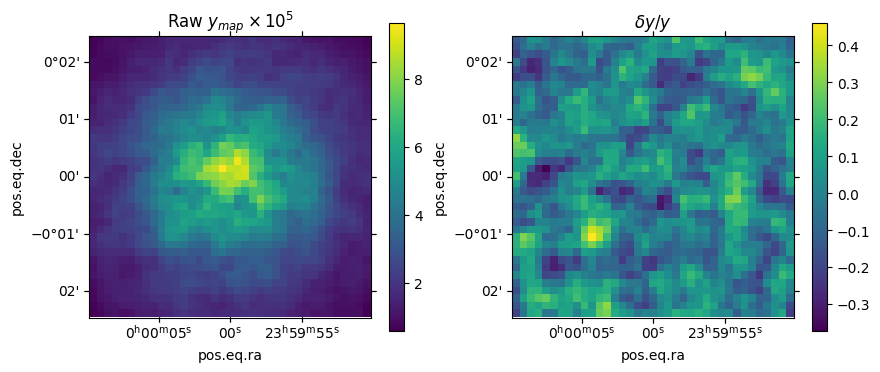

In [9]:
plt.figure(figsize=(10,4))
ax = plt.subplot(121, projection=WCS(base_cluster.get_map_header()))
plt.imshow(1e5*mock_img)
plt.colorbar()
plt.title(r'Raw $y_{map} \times 10^5$')

ax = plt.subplot(122, projection=WCS(base_cluster.get_map_header()))
plt.imshow((mock_img-mock_mod)/mock_mod)
plt.colorbar()
plt.title(r'$\delta y / y$')

Text(0, 0.5, '$\\sqrt{2 \\pi k^2 P_k}$')

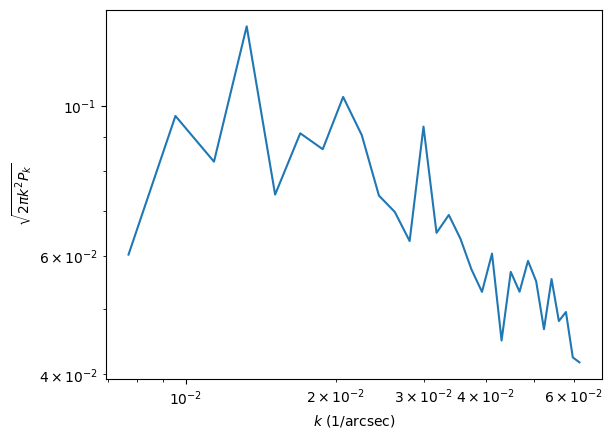

In [10]:
plt.loglog(k2d, (2*np.pi*k2d**2*mock_pk2d)**0.5)
plt.xlabel(r'$k$ (1/arcsec)')
plt.ylabel(r'$\sqrt{2 \pi k^2 P_k}$')

# Extract the constraint on the Pk parameters

In [11]:
samples_pk  = posterior_pk.sample((100000,), x=mock_pk2d, show_progress_bars=True)
samples_img = posterior_img.sample((100000,), x=((mock_img - mock_mod)/mock_mod).flatten(), show_progress_bars=True)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [12]:
samples_pk_df = pd.DataFrame.from_dict({par:np.asarray(samples_pk[:, i]) for i, par in enumerate(['norm', 'Linj'])})
chain_pk = Chain(samples = samples_pk_df, name="Pk based")

In [13]:
samples_img_df = pd.DataFrame.from_dict({par:np.asarray(samples_img[:, i]) for i, par in enumerate(['norm', 'Linj'])})
chain_img = Chain(samples = samples_img_df, name="Image based")

Parameter norm in chain Pk based is not constrained


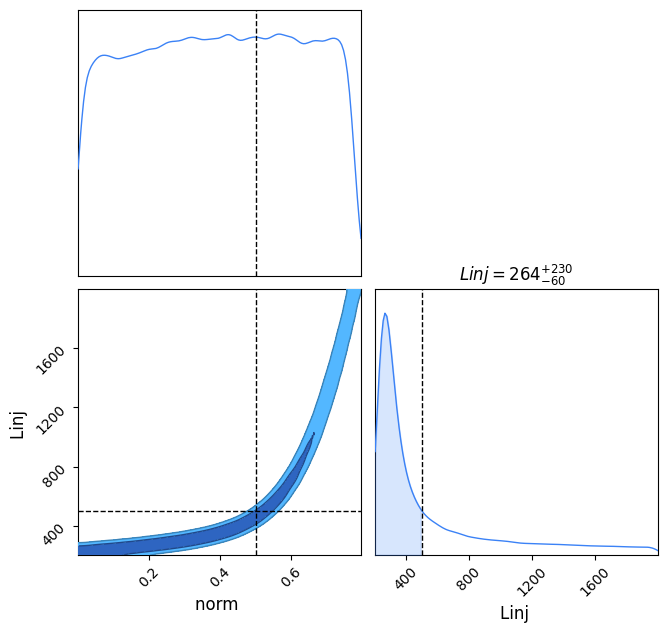

In [14]:
cc = ChainConsumer()
cc.add_chain(chain_pk)
truth = Truth(location={"norm": input_norm, "Linj": input_Linj})
cc.add_truth(truth)
cc.plotter.plot();

Parameter norm in chain Image based is not constrained
Parameter norm in chain Pk based is not constrained


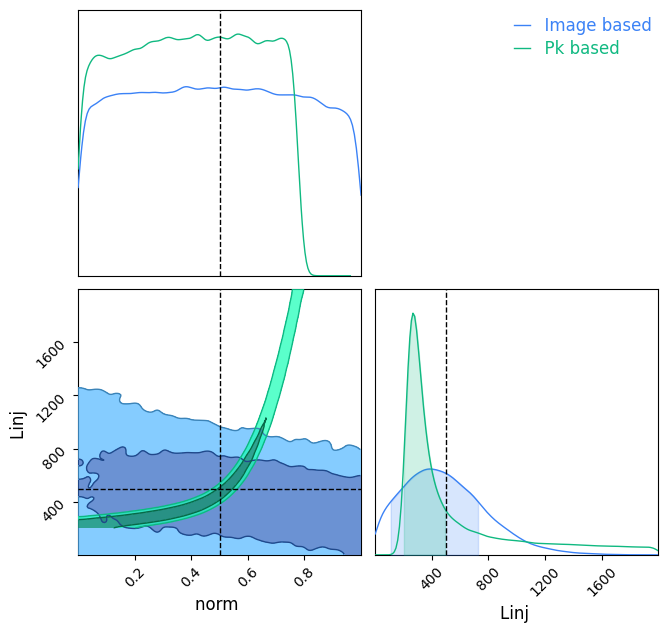

In [15]:
cc = ChainConsumer()
truth = Truth(location={"norm": input_norm, "Linj": input_Linj})
cc.add_truth(truth)
cc.add_chain(chain_img)
cc.add_chain(chain_pk)
cc.plotter.plot();

# Fit the data with PITSZI

In [16]:
# Define the data
cl_data = pitszi.Data(mock_img, base_cluster.get_map_header(), silent=True, output_dir=outdir)
Nx, Ny = mock_img.shape
cl_data.noise_mc = np.random.normal(0, 1e-10, (1000, Nx, Ny))
cl_data.set_noise_model_from_mc()
cl_data.noise_rms = cl_data.get_noise_rms_from_model(Nmc=100)
cl_data.noise_rms = gaussian_filter(cl_data.noise_rms,sigma=10/2.35/base_cluster.get_map_header()['CDELT2']/3600)

In [17]:
# Define the inference
test_cluster = copy.deepcopy(base_cluster)
cl_Finfer = pitszi.InferenceFluctuation(cl_data, test_cluster, method_use_covmat=False, silent=False, output_dir=outdir)

cl_Finfer.kbin_min   = kmin
cl_Finfer.kbin_max   = kmax
cl_Finfer.kbin_Nbin  = Npkbin
cl_Finfer.kbin_scale = 'lin'

cl_Finfer.nuisance_Anoise = 1

cl_Finfer.pk_setup(Nmc=1000)

                        _  _    ___  ____ _                 
                  _ __ (_)| |_ / __||_  /(_)                
                 | '_ \| ||  _|\__ \ / / | |                
                 | .__/|_| \__||___//___||_|                
                 |_|                                        
   Probing ICM Turbulence from Sunyaev-Zel'dovich Imaging   
------------------------------------------------------------
                 Fluctuation Inference                      
------------------------------------------------------------
----- Checking the inputs -----
      - Data1, data2, and model projection OK.
----- Running the setup -----
    * Setup imaging
    * Setup k binning
      - Counts in each k bin: [ 8.  8. 16. 12. 12. 20. 20. 20. 16. 32. 20. 36. 28. 32. 40. 32. 40. 32.
 52. 40. 48. 44. 52. 52. 52. 68. 40. 64. 56. 80.]
      - Minimal count in k bins: 8.0
    * Setup Pk data, ref model and noise
    * Setup window function conversion
    * Setup bin-to-bin mixing


In [18]:
# Fit parameters
fitpar_pk3d = {
        'Norm':{'guess':[0.5, 0.3],'unit': None,'limit':[0, 1]},
        'Linj':{'guess':[500, 300],'unit': u.kpc,'limit':[5, 1000]},    
    }

In [19]:
# Curve fit
plist, popt, pcov = cl_Finfer.run_curvefit_fluctuation(fitpar_pk3d,
                                                       show_fit_result=True,
                                                       include_model_error=True,
                                                       set_bestfit=False)

----- Checking the Pk setup -----
      The setup was done.
      We can proceed, but make sure that it was done with the correct analysis framework.
param 0 (Norm): 
   median   = 0.5175751134954905 -0.01149692707013128 +0.011770416807149853
   best-fit = 0.5250367126081116 -0.0189585261827524 +0.004308817694528733
   Norm = 0.5175751134954905_{-0.01149692707013128}^{0.011770416807149853}
param 1 (Linj): 
   median   = 483.1148943160714 -28.17437554967063 +28.90942140193738
   best-fit = 482.8877662607738 -27.947247494373016 +29.13654945723499
   Linj = 483.1148943160714_{-28.17437554967063}^{28.90942140193738}


In [20]:
# MCMC fit
cl_Finfer.mcmc_nwalkers = 20
cl_Finfer.mcmc_nsteps   = MCMC_Nstep
cl_Finfer.mcmc_burnin   = 100
cl_Finfer.mcmc_reset    = True
cl_Finfer.mcmc_run      = True

if do_mcmc:
    plist, sampler = cl_Finfer.run_mcmc_fluctuation(fitpar_pk3d, 
                                                    kind='projection', 
                                                    show_fit_result=True,
                                                    include_model_error=True,
                                                    set_bestfit=False)

# Compare SBI and PITSZI

In [21]:
# Extract chains according to curvefit results
def fake_chains_curvefit(parinfo, popt, pcov, Nsample=10000):
    par_chains = np.zeros((Nsample, len(popt)))
    isamp = 0
    while isamp < Nsample:
        param = np.random.multivariate_normal(popt, pcov)
        cond = np.isfinite(cl_Finfer.prior_fluctuation(param, parinfo))
        if cond:
            par_chains[isamp,:] = param
            isamp += 1
    return par_chains[np.newaxis]
    
pitszi_cf_chains = fake_chains_curvefit(fitpar_pk3d, popt, pcov)[0]

In [22]:
# Extract PITSZI chains
if do_mcmc:
    pitszi_mcmc_chains = sampler.chain[:,cl_Finfer.mcmc_burnin:,:]
    pitszi_mcmc_chains = pitszi_mcmc_chains.reshape((pitszi_mcmc_chains.shape[0]*pitszi_mcmc_chains.shape[1],pitszi_mcmc_chains.shape[2]))

In [23]:
# Make PITSZI chains
samples_cf_df = pd.DataFrame.from_dict({par:np.asarray(pitszi_cf_chains[:, i]) for i, par in enumerate(['norm', 'Linj'])})
chain_cf = Chain(samples = samples_cf_df, name="Pk PITSZI-curvefit based")

if do_mcmc:
    samples_mcmc_df = pd.DataFrame.from_dict({par:np.asarray(pitszi_mcmc_chains[:, i]) for i, par in enumerate(['norm', 'Linj'])})
    chain_mcmc = Chain(samples = samples_mcmc_df, name="Pk PITSZI-MCMC based")

Parameter norm in chain Pk based is not constrained


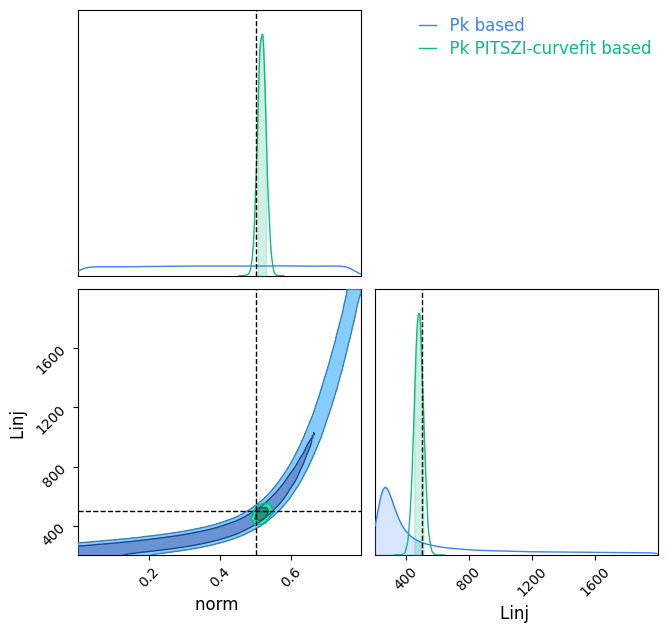

In [24]:
# Compare the chains
cc = ChainConsumer()
truth = Truth(location={"norm": input_norm, "Linj": input_Linj})
cc.add_truth(truth)
cc.add_chain(chain_pk)
cc.add_chain(chain_cf)
if do_mcmc: cc.add_chain(chain_mcmc)
cc.plotter.plot();

In [25]:
# Expected Pk with sample variance for the given model
pk_true_mc = []
for i in range(1000):
    pk_true_mc.append((2*np.pi*k2d**2 * simulator_pk(np.array([input_norm, input_Linj])))**0.5)
pk_true_mc = np.array(pk_true_mc)

# Sampling of model allowed by SBI constraint
pk_sbi_mc = []
pk_cf_mc = []
pk_mcmc_mc = []

for i in range(100):
    imc = int(np.random.uniform(0, len(chain_pk.data_samples['norm'].values)-2))
    pk_sbi_mc.append((2*np.pi*k2d**2 * simulator_pk(np.array([chain_pk.data_samples['norm'].values[imc], 
                                                              chain_pk.data_samples['Linj'].values[imc]])))**0.5)
    imc = int(np.random.uniform(0, len(chain_cf.data_samples['norm'].values)-2))
    pk_cf_mc.append((2*np.pi*k2d**2 * simulator_pk(np.array([chain_cf.data_samples['norm'].values[imc], 
                                                             chain_cf.data_samples['Linj'].values[imc]])))**0.5)
    if do_mcmc:
        imc = int(np.random.uniform(0, len(chain_mcmc.data_samples['norm'].values)-2))
        pk_mcmc_mc.append((2*np.pi*k2d**2 * simulator_pk(np.array([chain_mcmc.data_samples['norm'].values[imc], 
                                                                   chain_mcmc.data_samples['Linj'].values[imc]])))**0.5)
pk_sbi_mc = np.array(pk_sbi_mc)
pk_cf_mc = np.array(pk_cf_mc)
pk_mcmc_mc = np.array(pk_mcmc_mc)

Text(0, 0.5, '$\\sqrt{2 \\pi k^2 P_k}$')

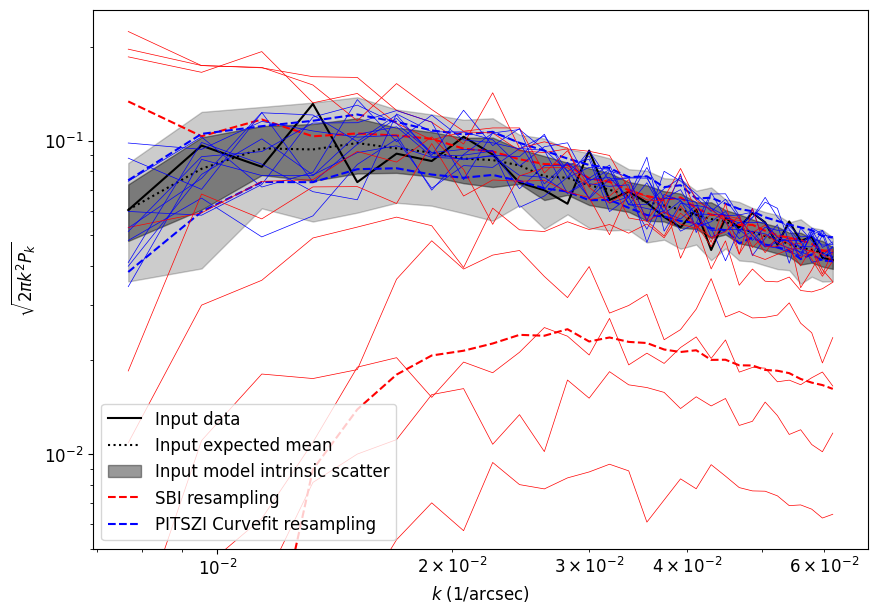

In [26]:
# Plot the Pk 2D and expected variance
plt.figure(figsize=(10,7))
plt.loglog(k2d, (2*np.pi*k2d**2*mock_pk2d)**0.5, color='k', label='Input data')
plt.loglog(k2d, np.mean(pk_true_mc, axis=0), color='k', ls=':', label='Input expected mean')
plt.fill_between(k2d, np.mean(pk_true_mc, axis=0)+np.std(pk_true_mc, axis=0), 
                 np.mean(pk_true_mc, axis=0)-np.std(pk_true_mc, axis=0), 
                 alpha=0.4, color='k', label='Input model intrinsic scatter')
plt.fill_between(k2d, np.mean(pk_true_mc, axis=0)+2*np.std(pk_true_mc, axis=0), 
                 np.mean(pk_true_mc, axis=0)-2*np.std(pk_true_mc, axis=0), 
                 alpha=0.2, color='k')
plt.plot(k2d, np.mean(pk_sbi_mc, axis=0)+np.std(pk_sbi_mc, axis=0), ls='--', color='red', label='SBI resampling')
plt.plot(k2d, np.mean(pk_sbi_mc, axis=0)-np.std(pk_sbi_mc, axis=0), ls='--', color='red')
plt.plot(k2d, np.mean(pk_cf_mc, axis=0)+np.std(pk_cf_mc, axis=0), ls='--', color='blue', label='PITSZI Curvefit resampling')
plt.plot(k2d, np.mean(pk_cf_mc, axis=0)-np.std(pk_cf_mc, axis=0), ls='--', color='blue')
if do_mcmc:
    plt.plot(k2d, np.mean(pk_mcmc_mc, axis=0)+np.std(pk_mcmc_mc, axis=0), ls='--', color='pink', label='PITSZI MCMC resampling')
    plt.plot(k2d, np.mean(pk_mcmc_mc, axis=0)-np.std(pk_mcmc_mc, axis=0), ls='--', color='pink')
for i in range(10):
    plt.loglog(k2d, pk_sbi_mc[i], color='red', lw=0.5)
    plt.loglog(k2d, pk_cf_mc[i],  color='blue', lw=0.5)
    if do_mcmc: plt.loglog(k2d, pk_mcmc_mc[i],  color='pink', lw=0.5)

plt.ylim(0.005,2*np.amax((2*np.pi*k2d**2*mock_pk2d)**0.5))
plt.legend()
plt.xlabel(r'$k$ (1/arcsec)')
plt.ylabel(r'$\sqrt{2 \pi k^2 P_k}$')

In [27]:
# Resampling for the 3D Pk
Nsamp = 1000
pk3d_sbi_mc = []
pk3d_cf_mc = []
pk3d_mcmc_mc = []
for i in range(Nsamp):
    imc = int(np.random.uniform(0, len(chain_pk.data_samples['norm'].values)-2))
    test_cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                               'statistics': 'gaussian',
                                               'Norm': chain_pk.data_samples['norm'].values[imc],
                                               'slope': -11./3,
                                               'Linj': chain_pk.data_samples['Linj'].values[imc]*u.kpc,
                                               'Ldis': 1*u.kpc}
    k3d, pk3d = test_cluster.get_pressure_fluctuation_spectrum()
    pk3d_sbi_mc.append((4*np.pi*k3d**3*pk3d).to_value('')**0.5)

    imc = int(np.random.uniform(0, len(chain_cf.data_samples['norm'].values)-2))
    test_cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                               'statistics': 'gaussian',
                                               'Norm': chain_cf.data_samples['norm'].values[imc],
                                               'slope': -11./3,
                                               'Linj': chain_cf.data_samples['Linj'].values[imc]*u.kpc,
                                               'Ldis': 1*u.kpc}
    k3d, pk3d = test_cluster.get_pressure_fluctuation_spectrum()
    pk3d_cf_mc.append((4*np.pi*k3d**3*pk3d).to_value('')**0.5)

    if do_mcmc: 
        imc = int(np.random.uniform(0, len(chain_mcmc.data_samples['norm'].values)-2))
        test_cluster.model_pressure_fluctuation = {'name': 'CutoffPowerLaw',
                                                   'statistics': 'gaussian',
                                                   'Norm': chain_mcmc.data_samples['norm'].values[imc],
                                                   'slope': -11./3,
                                                   'Linj': chain_mcmc.data_samples['Linj'].values[imc]*u.kpc,
                                                   'Ldis': 1*u.kpc}
        k3d, pk3d = test_cluster.get_pressure_fluctuation_spectrum()
        pk3d_mcmc_mc.append((4*np.pi*k3d**3*pk3d).to_value('')**0.5)

Text(0, 0.5, '$\\sqrt{4 \\pi k^3 P_k}$')

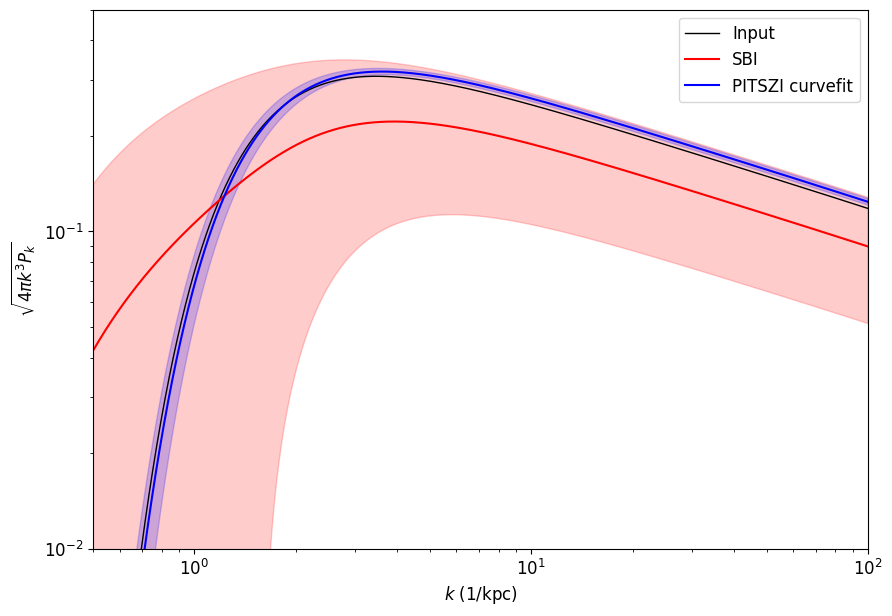

In [28]:
# Plot the 3D Pk resampling
k3d, pk3d_true = base_cluster.get_pressure_fluctuation_spectrum()

plt.figure(figsize=(10,7))
plt.loglog(k3d, (4*np.pi*k3d**3*pk3d_true).to_value('')**0.5, color='k', lw=1, label='Input')
plt.loglog(k3d, np.mean(pk3d_sbi_mc, axis=0), color='red', label='SBI')
plt.fill_between(k3d.value, np.mean(pk3d_sbi_mc, axis=0)+np.std(pk3d_sbi_mc, axis=0), 
                 np.mean(pk3d_sbi_mc, axis=0)-np.std(pk3d_sbi_mc, axis=0), color='red', alpha=0.2)
plt.loglog(k3d, np.mean(pk3d_cf_mc, axis=0), color='blue', label='PITSZI curvefit')
plt.fill_between(k3d.value, np.mean(pk3d_cf_mc, axis=0)+np.std(pk3d_cf_mc, axis=0), 
                 np.mean(pk3d_cf_mc, axis=0)-np.std(pk3d_cf_mc, axis=0), color='blue', alpha=0.2)
if do_mcmc: 
    plt.loglog(k3d, np.mean(pk3d_cf_mc, axis=0), color='pink', label='PITSZI MCMC')
    plt.fill_between(k3d.value, np.mean(pk3d_mcmc_mc, axis=0)+np.std(pk3d_mcmc_mc, axis=0), 
                     np.mean(pk3d_mcmc_mc, axis=0)-np.std(pk3d_mcmc_mc, axis=0), color='pink', alpha=0.2)
plt.ylim(0.01,0.5)
plt.xlim(0.5,100)
plt.legend()
plt.xlabel(r'$k$ (1/kpc)')
plt.ylabel(r'$\sqrt{4 \pi k^3 P_k}$')